In [1]:
# Import libraries
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import random
import os

Using TensorFlow backend.


In [2]:
# Constants
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [3]:
# Training data
img_names = os.listdir("dogs-vs-cats/train/train")
categories = []
for img_name in img_names:
    category = img_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'imageName': img_names,
    'category': categories
})

In [11]:
# Build model
model = Sequential()

# Layer 1
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
#model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Layer 2
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation = 'relu'))
#model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Layer 3
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation = 'relu'))
#model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Layer 4
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation = 'relu'))
#model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Fully Connected layer
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 30, 30, 64)       

In [12]:
# Callbacks
earlystop = EarlyStopping(patience = 10)

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [13]:
# Prepare data
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) #Convert 1 to dog and 0 to cat

train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42)
train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [14]:
# Training generator
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dogs-vs-cats/train/train/", 
    x_col = 'imageName',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
# Validation generator
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "dogs-vs-cats/train/train/", 
    x_col = 'imageName',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
epochs = 30
# Fit model
history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks
)

# Save model
model.save_weights("model.h5")

Epoch 1/30
1333/1333 [==============================] - 765s 574ms/step - loss: 1.1880 - accuracy: 0.6148 - val_loss: 1.4820 - val_accuracy: 0.5616
Epoch 2/30
1333/1333 [==============================] - 696s 522ms/step - loss: 0.5950 - accuracy: 0.6936 - val_loss: 0.6142 - val_accuracy: 0.7194
Epoch 3/30
1333/1333 [==============================] - 692s 519ms/step - loss: 0.5503 - accuracy: 0.7294 - val_loss: 0.8634 - val_accuracy: 0.6973
Epoch 4/30
1333/1333 [==============================] - 692s 519ms/step - loss: 0.5023 - accuracy: 0.7608 - val_loss: 0.8852 - val_accuracy: 0.7569
Epoch 5/30
1333/1333 [==============================] - 692s 519ms/step - loss: 0.4477 - accuracy: 0.7946 - val_loss: 1.8600 - val_accuracy: 0.6070
Epoch 6/30
1333/1333 [==============================] - 696s 522ms/step - loss: 0.4069 - accuracy: 0.8222 - val_loss: 0.8443 - val_accuracy: 0.7494

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/30
1333/1333 [=========

No handles with labels found to put in legend.


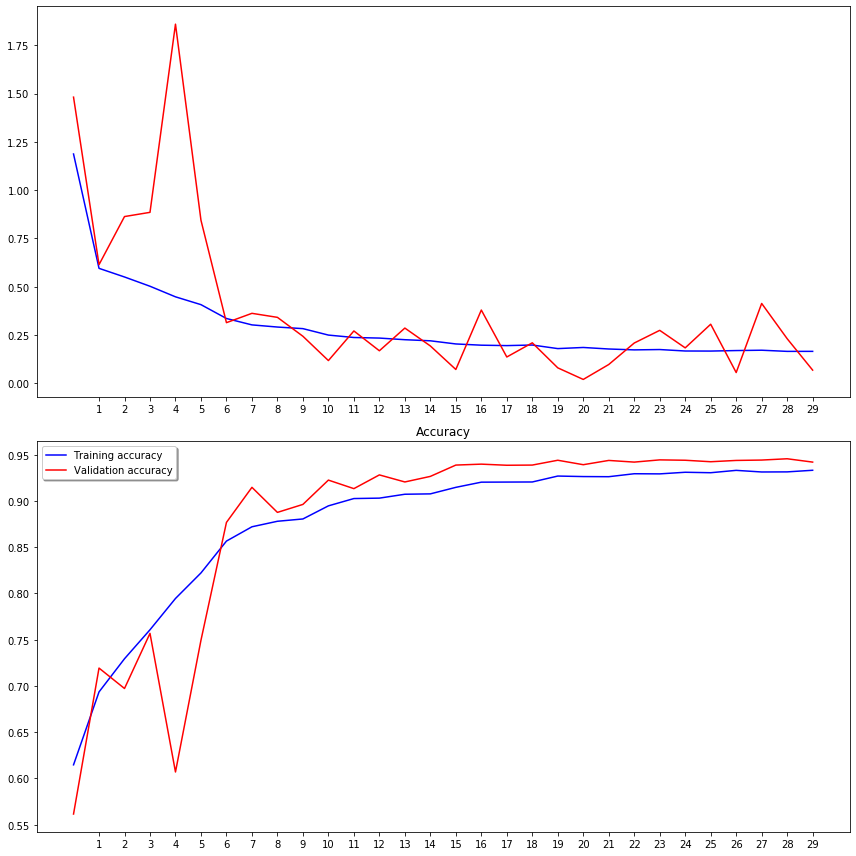

In [17]:
# Virtualize training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))

ax1.plot(history.history['loss'], color = 'blue', label = "Training loss")
ax1.plot(history.history['val_loss'], color = 'red', label = "validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
legend = plt.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.title("Loss")
#plt.show()

ax2.plot(history.history['accuracy'], color = 'blue', label = "Training accuracy")
ax2.plot(history.history['val_accuracy'], color = 'red',label = "Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
legend = plt.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.title("Accuracy")
plt.show()

In [18]:
# Prepare testing data
test_filenames = os.listdir("dogs-vs-cats/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Testing generator
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "dogs-vs-cats/test", 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 12500 validated image filenames.


In [19]:
# Predict
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples / batch_size))
test_df['category'] = np.argmax(predict, axis = -1) # Pick the category with the highest probablity

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

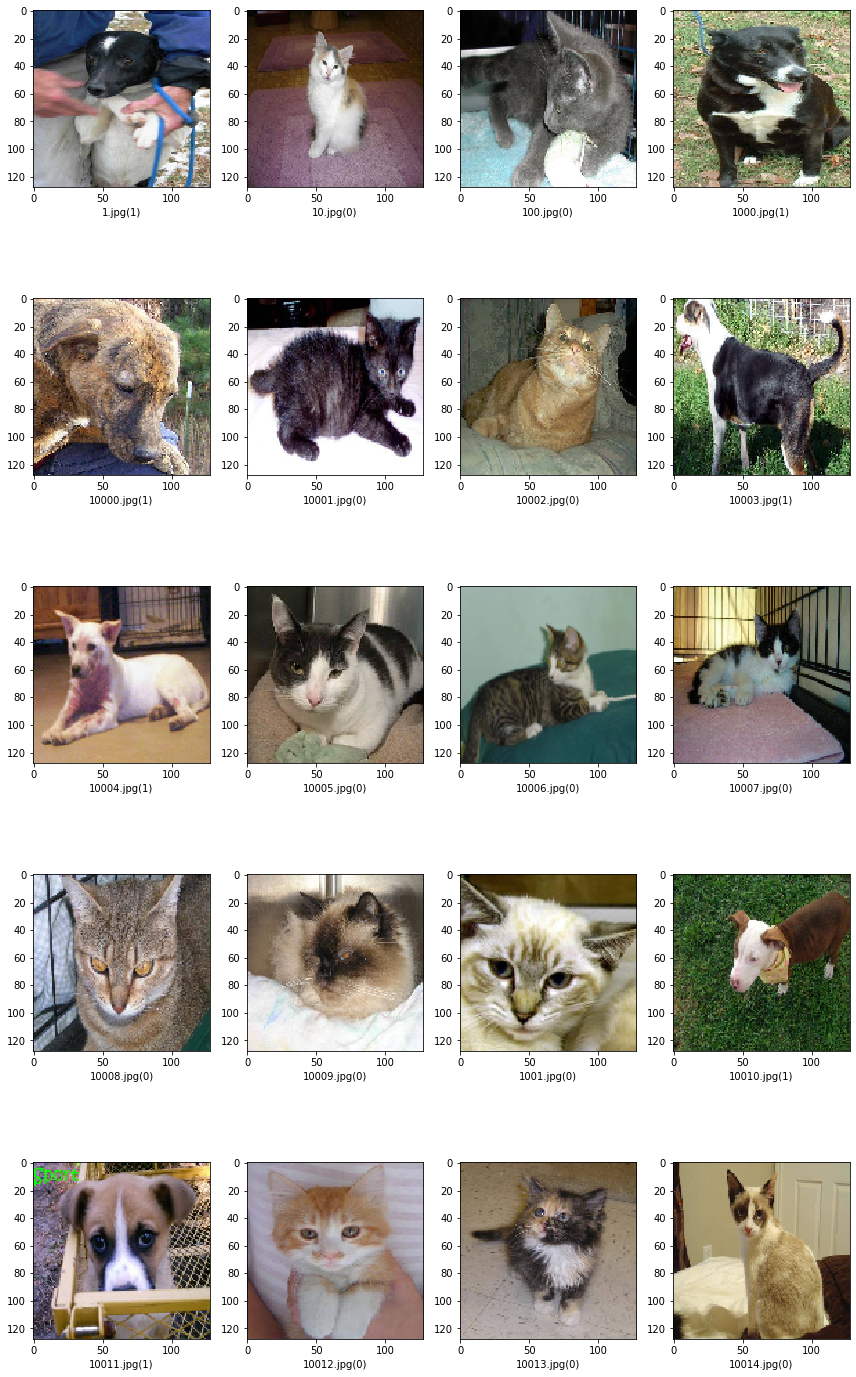

In [20]:
# Predicted result with images
sample_test = test_df.head(20)
sample_test.head()
plt.figure(figsize = (12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("dogs-vs-cats/test/" + filename, target_size = IMAGE_SIZE)
    plt.subplot(6, 4, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()